## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

import re # regular expression
import random
from itertools import groupby

# select plot style
plt.style.use('fivethirtyeight')

## Load Dataset


In [2]:
# we only want the training partition
dataset_raw = tfds.load("tiny_shakespeare")['train']

Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteBRFTA7/tiny_shakespeare-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteBRFTA7/tiny_shakespeare-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteBRFTA7/tiny_shakespeare-test.tfrecord


Dataset tiny_shakespeare downloaded and prepared to /root/tensorflow_datasets/tiny_shakespeare/1.0.0. Subsequent calls will reuse this data.


## Preprocess Dataset

In [3]:
# Convert dataset into one string
dataset_as_string = [elem['text'].numpy().decode("utf-8") for elem in dataset_raw][0]
print(type(dataset_as_string))

<class 'str'>


In [4]:
# Remove new-line-characters
print("Before:\n", repr(dataset_as_string[0:40]))
str_1 = re.sub(r'\n', ' ', dataset_as_string) 
print("After:\n", repr(str_1[0:40]))

Before:
 'First Citizen:\nBefore we proceed any fur'
After:
 'First Citizen: Before we proceed any fur'


In [5]:
# Remove Special Characters and convert to lower case
i = str_1.find("&")
reference = str_1[i+10:i+20]
print("Before:\n", repr(str_1[i-20:i+20]))
str_2 = re.sub(r'[^a-z0-9 ]+', '', str_1.lower())
i = str_2.find(reference)
print("After:\n", repr(str_2[i-25:i+20]))

Before:
 "ld goat!  Senators, &C: We'll surety him"
After:
 'ld goat  senators c well surety him  cominius'


In [6]:
# Split String into word tokens and remove empty tokens ''
print("Before:\n", str_2[0:20])
word_data = str_2.split(" ")
word_data = [word for word in word_data if word != '']
print("After:\n", word_data[0:3])

Before:
 first citizen before
After:
 ['first', 'citizen', 'before']


In [7]:
# list of unique words, we will need later
word_unique = list(set(word_data))

In [8]:
# Create ID dicts
word_to_id = {}
id_to_word = {}

for id, word in enumerate(set(word_data)):
    word_to_id[word] = id
    id_to_word[id] = word

In [9]:
# Create Frequency dict
word_to_frequency = {}

for word in word_data:
    if word in word_to_frequency:
        word_to_frequency[word] += 1
    else:
        word_to_frequency[word] = 1

total_word_num = len(word_data)
word_to_frequency = {word: n/total_word_num for word, n in word_to_frequency.items()}


In [10]:
word_to_frequency["the"]

0.031332536960119235

In [11]:
def subsample(word, s = 0.001):
    z_w = word_to_frequency[word]
    return (np.sqrt(z_w/s) + 1) * (s/z_w)

In [12]:
subsample("tree")

42.54022367327437

In [13]:
# Create Dataset with target context pairs [target_word, context_word] with subsampling
context_window = 4

positive_pairs = []

positive_pairs_int = []

# stored as ids
word_to_context = {}

for i, word in enumerate(word_data):
    for ii in range(1, context_window+1):
        if (i - ii) > 0 and (i + ii) < total_word_num:

            target_subsample_prob = subsample(word)
            if np.random.random() < target_subsample_prob:

                context_left = word_data[i-ii]
                context_left_subsample_prob = subsample(context_left)
                if np.random.random() < context_left_subsample_prob:
                    positive_pairs.append([word, context_left])
                    positive_pairs_int.append([word_to_id[word], word_to_id[context_left], 1])
                    try:
                        word_to_context[word_to_id[word]] += [word_to_id[context_left]]
                    except KeyError:
                        word_to_context[word_to_id[word]] = [word_to_id[context_left]]

                context_right = word_data[i+ii]
                context_right_subsample_prob = subsample(context_right)
                if np.random.random() < context_right_subsample_prob:
                    positive_pairs.append([word, context_right])
                    positive_pairs_int.append([word_to_id[word], word_to_id[context_right], 1])
                    try:
                        word_to_context[word_to_id[word]] += [word_to_id[context_right]]
                    except KeyError:
                        word_to_context[word_to_id[word]] = [word_to_id[context_right]]
            

In [14]:
print(len(positive_pairs))
positive_pairs[0:10]

852163


[['before', 'citizen'],
 ['before', 'we'],
 ['we', 'before'],
 ['we', 'proceed'],
 ['we', 'citizen'],
 ['we', 'any'],
 ['proceed', 'any'],
 ['proceed', 'before'],
 ['proceed', 'further'],
 ['proceed', 'citizen']]

In [15]:
positive_pairs_int[0:10]

[[828, 1459, 1],
 [828, 5542, 1],
 [5542, 828, 1],
 [5542, 3157, 1],
 [5542, 1459, 1],
 [5542, 5102, 1],
 [3157, 5102, 1],
 [3157, 828, 1],
 [3157, 11274, 1],
 [3157, 1459, 1]]

## Negative Sampling

In [16]:
# This may take some time
# increase subsampling parameter for faster performance
s = 20

# For each pair we want to include n negative samples
# a negative context word is more likely to appear if it has a higher frequency in the corpus
n = 2

word_num = len(word_to_id)

negative_pairs_int = []

for pair in positive_pairs_int:
    for i in range(n):
        valid_sample = False
        while not valid_sample:
            potential_sample = np.random.randint(0,word_num)
            # check if sample is context word of target
            if potential_sample not in word_to_context[pair[0]]:
                # if sample really is a negative context word
                # we decide if we want to select it based on its frequency in the corpus
                # for that we just use and adjusted inverse subsampling (increase scaler for faster runtime)
                potential_sample_freq = s/subsample(id_to_word[potential_sample])
                if np.random.random() < potential_sample_freq:
                    negative_pairs_int.append([pair[0], potential_sample, 0])
                    valid_sample = True



In [17]:
negative_pairs_int[0:10]

[[828, 9012, 0],
 [828, 4819, 0],
 [828, 4287, 0],
 [828, 6482, 0],
 [5542, 4561, 0],
 [5542, 8444, 0],
 [5542, 9150, 0],
 [5542, 6296, 0],
 [5542, 8072, 0],
 [5542, 393, 0]]

In [18]:
for pair in negative_pairs_int[0:10]:
    print(id_to_word[pair[0]], id_to_word[pair[1]])

before taking
before takest
before scarfs
before about
we shrug
we counsellor
we offend
we smotherd
we shroud
we appertaining


## Create Dataset

In [19]:
# Concatinate positive and negative samples and shuffle them
target_input_pairs = positive_pairs_int + negative_pairs_int
random.shuffle(target_input_pairs)
len(target_input_pairs)

2556489

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(target_input_pairs)

print("dataset length: ", len(dataset))

i = 0
for elem in dataset:
    print(elem)
    if i == 10:
        break
    i+=1

batch_size = 64
dataset = dataset.batch(batch_size)

dataset length:  2556489
tf.Tensor([3034 4427    1], shape=(3,), dtype=int32)
tf.Tensor([8529 6656    1], shape=(3,), dtype=int32)
tf.Tensor([5531 8637    1], shape=(3,), dtype=int32)
tf.Tensor([789 297   0], shape=(3,), dtype=int32)
tf.Tensor([4517 8753    0], shape=(3,), dtype=int32)
tf.Tensor([10693   671     0], shape=(3,), dtype=int32)
tf.Tensor([ 261 3857    0], shape=(3,), dtype=int32)
tf.Tensor([3133 9724    0], shape=(3,), dtype=int32)
tf.Tensor([10908  3601     0], shape=(3,), dtype=int32)
tf.Tensor([9175 1953    0], shape=(3,), dtype=int32)
tf.Tensor([ 171 9579    1], shape=(3,), dtype=int32)


## SkipGram

In [21]:
class SkipGram(Model):
  def __init__(self,  embedding_size = 100, input_dim = len(word_to_id)):
    super(SkipGram, self).__init__()
    self.target_embedding = tf.keras.layers.Embedding(input_dim, 
                                                      embedding_size,
                                                     ) 
    
    self.context_embedding =tf.keras.layers.Embedding(input_dim, 
                                                      embedding_size,
                                                     )
    
    self.dots = tf.keras.layers.Dot(axes=(1))
    self.flatten = tf.keras.layers.Flatten()

  def call(self, pair, training = False):
    target = pair[:,0]
    context = pair[:,1]
    if training == True:
        label = tf.cast(tf.expand_dims(pair[:,2], -1), dtype=tf.float32)


    target_embedding = self.target_embedding(target)
    if training == False:
        return target_embedding

    context_embedding = self.context_embedding(context)
  
    # The dot product of the embedding tells us how similar the embeddings are
    # positive -> similar
    # negative -> not similar
    similarity_log = self.flatten(self.dots([context_embedding, target_embedding]))

    # we treat the dot product as logits and compare the similarity with
    # the labels using cross entropy
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=similarity_log, labels=label)

    return tf.reduce_mean(loss)

  
  
  def get_embeddings(self, words):

    return self.target_embedding(words)
    
    


In [22]:
test_gram = SkipGram(3)

for elem in dataset:
    a = elem
    break

test_gram(a).numpy()[0]

array([ 0.04196471, -0.01331574,  0.01062175], dtype=float32)

## Train SkipGram

In [23]:
def train_step(model, data, optimizer):
    with tf.GradientTape() as tape:
        loss = model(data, training = True)
        gradients = tape.gradient(loss, model.trainable_variables)
       
        # if the distance between prediction and label is < 0.5 
        # for the respective query elements we say the prediction is correct
        # accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.greater(pred,0.5), tf.equal(label,1)), dtype=tf.float32))
        
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [24]:
len(dataset)

39946

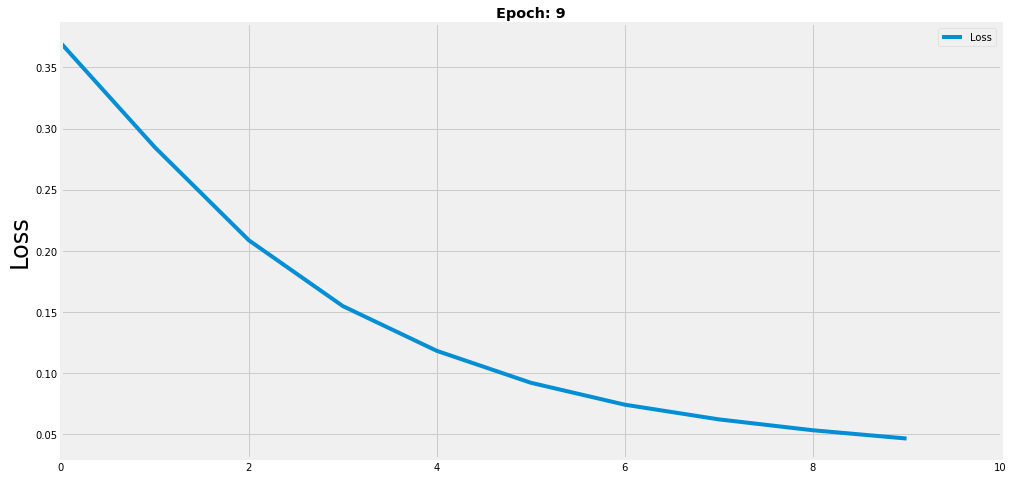

In [28]:
tf.keras.backend.clear_session()
from IPython.display import clear_output

num_epochs = 10
data_size = 20000
learning_rate = 0.001
embedding_size = 110
running_average_factor = 0.95

skip_gram = SkipGram(embedding_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)

losses = []

for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    #dataset = dataset.shuffle(data_size)

    running_average_loss = 0

    d = 0
    for data in dataset:#.take(data_size):
        d+=1
        if d%1000 == 0:
          print(d)
        loss = train_step(skip_gram, data, optimizer)
        running_average_loss = np.mean((running_average_factor * running_average_loss  + (1 - running_average_factor) * loss).numpy())
        
    losses.append(running_average_loss)

    # Every Epoch we embed every word and calculate the k nearest neighbor of the following words
    # queen, throne, wine, poison, love, strong, day
    k = 4 # mind the formatting when changing this

    embeddings = skip_gram.get_embeddings(tf.constant([word_to_id[word] for word in word_unique]))

    words = ["queen", "throne", "wine", "poison", "love", "strong", "day"]

    # closer to -1 means more similar
    cosine = tf.keras.losses.CosineSimilarity(axis=0)

    for word in words:
        embedding = skip_gram.get_embeddings(tf.constant(word_to_id[word]))
        cosine_similarity = np.array([cosine(embedding, other_embed).numpy() for other_embed in embeddings])
        # sort by similarity and return k most similar idxs
        most_sim = [id_to_word[neighbour] for neighbour in cosine_similarity.argsort()[1:k+1]]

        print('{:12s} {:12s} {:12s} {:12s} {:12s}'.format(word+": ", most_sim[0],  most_sim[1], most_sim[2], most_sim[3]))
    

    # Plotting
    clear_output(wait=True) 
    fontsize=24

    fig, ax = plt.subplots(1,1,sharex=True,figsize=(15,8))

    ax.set_xlim((0,num_epochs))
    ax.plot(losses,label="Loss")
    
    ax.set_ylabel("Loss",fontsize=fontsize)
    ax.set_title("Epoch: " + str(epoch), fontweight="bold")
    ax.legend()

    plt.show()


## Visualize Embeddings

In [33]:
k = 4

embeddings = skip_gram.get_embeddings(tf.constant([word_to_id[word] for word in word_unique]))

words = ["water", "fire", "bread"]

# closer to -1 means more similar
cosine = tf.keras.losses.CosineSimilarity(axis=0)

for word in words:
    embedding = skip_gram.get_embeddings(tf.constant(word_to_id[word]))
    cosine_similarity = np.array([cosine(embedding, other_embed).numpy() for other_embed in embeddings])
    # sort by similarity and return k most similar idxs
    most_sim = [id_to_word[neighbour] for neighbour in cosine_similarity.argsort()[1:k+1]]

    print('{:12s} {:12s} {:12s} {:12s} {:12s}'.format(word+": ", most_sim[0],  most_sim[1], most_sim[2], most_sim[3]))

water:       bled         bestrewd     diet         quarrelling 
fire:        figuring     thirst       term         discern     
bread:       hunger       starved      wakened      sued        


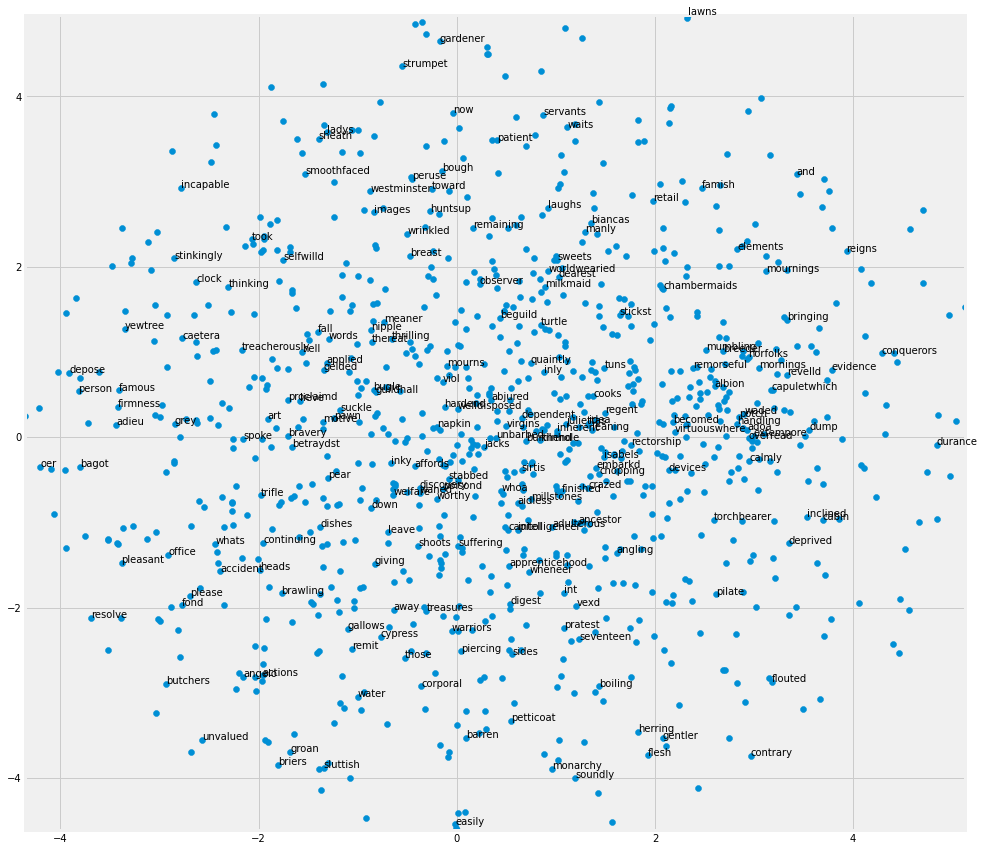

In [31]:
# Import t-SNE
from sklearn.manifold import TSNE

word_num = 1000

# Input words
word_labels = word_unique[0:word_num]

# Create embedding for first 1000 test images
embeddings = skip_gram.get_embeddings(tf.constant([word_to_id[word] for word in word_unique[0:word_num]]))

tsne = TSNE(n_components=2)

tsne_coord = tsne.fit_transform(embeddings)
x_coords = tsne_coord[:, 0]
y_coords = tsne_coord[:, 1]


fig = plt.figure(figsize=(15,15))
plt.subplot(1,1,1)


# display scatter plot
scatter = plt.scatter(x_coords, y_coords)

# we dont want to annotate every word only every
n = 5 #th

i = 0
for label, x, y in zip(word_labels, x_coords, y_coords):
    if i%n == 0:
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    i += 1

plt.show()